In [4]:
import warnings
warnings.filterwarnings('ignore')

# necessary packages
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

# additional certain short functions
from torch import is_tensor
from matplotlib.pyplot import pause
from random import randint
from copy import deepcopy
from math import floor, ceil
from torch import stack
from torch import cat

ground truth =  Sandal
Dataset size =  60000


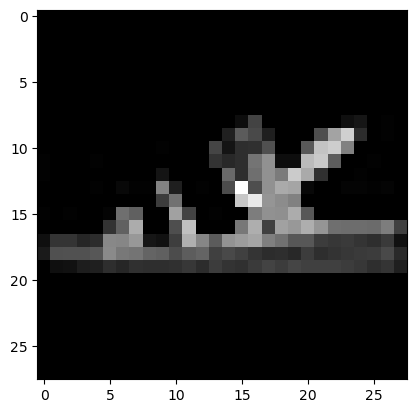

In [5]:
# get training dataset
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# get testing dataset
testing_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# class names
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# print random item to visualize
rand = random.randint(0, 59999)
img = training_data.data[rand]
plt.imshow(img, cmap='gray')
print("ground truth = ", training_data.classes[training_data.targets[rand]])

# print dataset size 
size = len(training_data)
print("Dataset size = ", size)

In [6]:
# object picking function
def pick(dataset: datasets, name: list, number: int) -> list:
    i = 0
    counter = [0] * len(name)
    score = []
    while True:
        if dataset.classes[dataset.targets[i]] in name and \
            counter[name.index(dataset.classes[dataset.targets[i]])] < 20:
                score = cat((score, dataset.data[i]), dim=0)
                counter[name.index(dataset.classes[dataset.targets[i]])] += 1
        i += 1
        correct = 0
        for j in range(len(name)):
            if counter[j] == 20:
                correct += 1
        if correct == len(name):
            break

In [1]:
l = ["apple", "apple", "candle"]
print(l.index("apple"))

thisdict = {
    0 : "Ford",
    1 : "Mustang",
    2 : 1964,
    3 : 2020
}
print(thisdict[3])

counter = [0] * 10
print(counter)

0
2020
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
